**Fourth Project Drowsiness detection**

In [1]:
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os

import numpy as np
import os, shutil
import pandas as pd

import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_theme(style="white")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import MaxNorm
from scikeras.wrappers import KerasClassifier
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from lime import lime_image
from skimage.segmentation import mark_boundaries

# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

import warnings
warnings.filterwarnings("ignore")

Let us try to preview some of our data

In [2]:
# Directory path
data_dir = 'data/'

In [3]:
# Get all the data in the directory data/validation (132 images), and reshape them
img_generator = ImageDataGenerator().flow_from_directory(data_dir, batch_size=4000)
images, labels = next(img_generator)

Found 4000 images belonging to 2 classes.


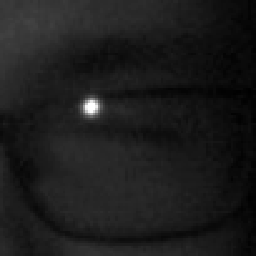

In [4]:
# Preview an image
array_to_img(images[0])

In [5]:
images.shape

(4000, 256, 256, 3)

In [6]:
images[0]

array([[[90., 90., 90.],
        [90., 90., 90.],
        [90., 90., 90.],
        ...,
        [48., 48., 48.],
        [48., 48., 48.],
        [48., 48., 48.]],

       [[90., 90., 90.],
        [90., 90., 90.],
        [90., 90., 90.],
        ...,
        [48., 48., 48.],
        [48., 48., 48.],
        [48., 48., 48.]],

       [[90., 90., 90.],
        [90., 90., 90.],
        [90., 90., 90.],
        ...,
        [48., 48., 48.],
        [48., 48., 48.],
        [48., 48., 48.]],

       ...,

       [[76., 76., 76.],
        [76., 76., 76.],
        [76., 76., 76.],
        ...,
        [51., 51., 51.],
        [51., 51., 51.],
        [51., 51., 51.]],

       [[76., 76., 76.],
        [76., 76., 76.],
        [76., 76., 76.],
        ...,
        [51., 51., 51.],
        [51., 51., 51.],
        [51., 51., 51.]],

       [[76., 76., 76.],
        [76., 76., 76.],
        [76., 76., 76.],
        ...,
        [51., 51., 51.],
        [51., 51., 51.],
        [51., 51., 51.]]

In [7]:
labels[0]

array([1., 0.], dtype=float32)

In [8]:
img_generator.class_indices

{'Closed_Eyes': 0, 'Open_Eyes': 1}

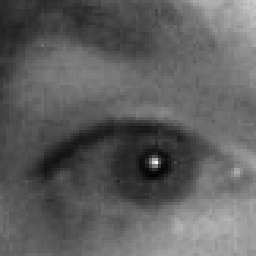

In [9]:
# Preview an image
array_to_img(images[4])

In [10]:
labels[6]

array([0., 1.], dtype=float32)

In [11]:
labels.shape

(4000, 2)

In [12]:
labels

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [13]:
labs=labels[:,1]

In [14]:
labs.shape

(4000,)

In [15]:
labs[6]

1.0

### Naive Model

In [16]:
# create model
#Sequential: multiple layers built on top of each other

model = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(256,256,3)))
#MaxPooling with filter size 2 and stride 2
model.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model.add(layers.Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [17]:
X=images
y=labs

In [18]:
history = model.fit(X, y, epochs=15, batch_size=10, 
                        validation_split=0.2, verbose=1)

Epoch 1/15
320/320 [==============================] - 94s 290ms/step - loss: 64.3770 - acc: 0.7824 - val_loss: 0.2174 - val_acc: 0.9588
Epoch 2/15
320/320 [==============================] - 80s 243ms/step - loss: 0.1598 - acc: 0.9653 - val_loss: 0.1103 - val_acc: 0.9700
Epoch 3/15
320/320 [==============================] - 45s 139ms/step - loss: 0.0479 - acc: 0.9854 - val_loss: 0.1401 - val_acc: 0.9787
Epoch 4/15
320/320 [==============================] - 49s 152ms/step - loss: 0.0285 - acc: 0.9922 - val_loss: 0.1105 - val_acc: 0.9825
Epoch 5/15
320/320 [==============================] - 52s 163ms/step - loss: 0.0143 - acc: 0.9956 - val_loss: 0.0928 - val_acc: 0.9862
Epoch 6/15
320/320 [==============================] - 44s 139ms/step - loss: 0.0082 - acc: 0.9979 - val_loss: 0.1133 - val_acc: 0.9862
Epoch 7/15
320/320 [==============================] - 50s 157ms/step - loss: 0.0057 - acc: 0.9985 - val_loss: 0.0912 - val_acc: 0.9887
Epoch 8/15
320/320 [==============================] - 

In [19]:
def visualize_training_results(results):
#Extracting the history from the results of the model
    history = results.history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
#Plotting Train and Validation Accuracy
    ax1.plot(history['val_acc'])
    ax1.plot(history['acc'])
#Setting legend, title and labels
    ax1.legend(['val_acc', 'acc'], loc='best')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
#Plotting Train and Validation Loss    
    ax2.plot(history['val_loss'])
    ax2.plot(history['loss'])
#Setting legend, title and labels
    ax2.legend(['val_loss', 'loss'], loc='best')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

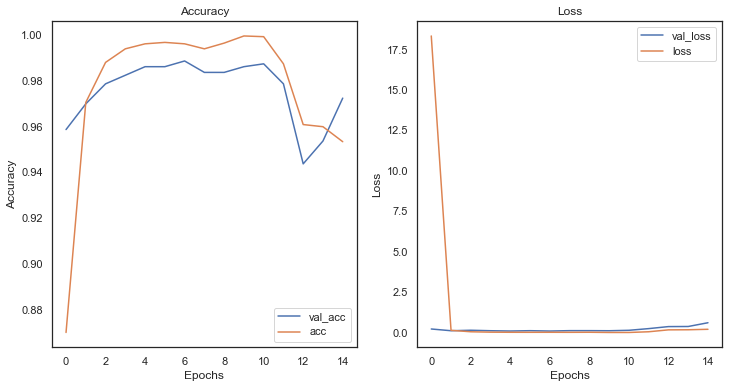

In [20]:
visualize_training_results(history)

In [21]:
def conf_matrix(model, trainX, trainy):
    seed = 42
    tf.random.set_seed(seed)
    y_pred_prob = model.predict(trainX, verbose=0)
    # predict classes
    y_pred_clas = (model.predict(trainX) > 0.5).astype("float")
    # confusion matrix
    cnm = confusion_matrix(trainy, y_pred_clas)
    # To Normalize
    cnm = cnm.astype('float') / cnm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cnm, annot=True, fmt='.2f', cmap="Oranges")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show(block=False)

In [ ]:
conf_matrix(model, X, y)